## 1. Бейзлайн из прошлого этапа

##### Для начала построим рекомендации, используя только ItemKNN, iALS, популярность и среднюю со-встречаемость

In [1]:
import os
import pandas as pd
import numpy as np
os.chdir(r"C:\Users\..\Desktop\WBTECH")

In [2]:
from rectools.metrics import (
    HitRate,
    Serendipity,
    calc_metrics,
    Recall,
    MAP,
    MRR,
    AvgRecPopularity
)
from rectools import Columns
from rectools.dataset import Dataset

In [ ]:
import threadpoolctl
from implicit.als import AlternatingLeastSquares
from rectools.models import ImplicitALSWrapperModel

In [ ]:
# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

In [571]:
first_train = pd.read_parquet('first_train_2.parquet')
first_val = pd.read_parquet('first_val_2.parquet')

In [124]:
items = pd.read_parquet('items_full_wo_emb.parquet')

In [572]:
num_threads = os.cpu_count()

In [573]:
catalog = first_train[Columns.Item].unique()

In [574]:
metrics = {
    "hit_rate@1": HitRate(k=1),
    "hit_rate@5": HitRate(k=5),
    "hit_rate@10": HitRate(k=10),
    "Recall@1": Recall(k=1),
    "Recall@5": Recall(k=5),
    "Recall@10": Recall(k=10),
    "MAP@1": MAP(k=1),
    "MAP@5": MAP(k=5),
    "MAP@10": MAP(k=10),
    "MRR@1": MRR(k=1),
    "MRR@5": MRR(k=5),
    "MRR@10": MRR(k=10),
    "pop_bias@10": AvgRecPopularity(k=10),
    "serendipity@10": Serendipity(k=10),
}

In [302]:
ials_recommendations_df = pd.read_parquet('ials_val.parquet')
ials_feat_recommendations_df = pd.read_parquet('ials_feat_val.parquet')
bm_25_recommendations_df = pd.read_parquet('bm25_val.parquet')
tfidf_recommendations_df = pd.read_parquet('tfidf_val.parquet')

In [303]:
models_results_df_val = pd.DataFrame(index=list(metrics.keys()))

In [304]:
ials_metrics = calc_metrics(
    metrics=metrics,
    reco=ials_recommendations_df,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)

models_results_df_val["iALS"] = [ials_metrics[metric] for metric in models_results_df_val.index]

fials_metrics = calc_metrics(
    metrics=metrics,
    reco=ials_feat_recommendations_df,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)

models_results_df_val["iALS_w_f"] = [fials_metrics[metric] for metric in models_results_df_val.index]

second_itemknn_metrics = calc_metrics(
    metrics=metrics,
    reco=tfidf_recommendations_df,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)

models_results_df_val["ItemKNN_TF-IDF"] = [second_itemknn_metrics[metric] for metric in models_results_df_val.index]

itemknn_metrics = calc_metrics(
    metrics=metrics,
    reco=bm_25_recommendations_df,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)

models_results_df_val["ItemKNN_BM25"] = [itemknn_metrics[metric] for metric in models_results_df_val.index]

In [305]:
models_results_df_val

,iALS,iALS_w_f,ItemKNN_TF-IDF,ItemKNN_BM25
hit_rate@1,0.310777,0.319607,0.315944,0.317255
hit_rate@5,0.547677,0.548294,0.537883,0.542472
hit_rate@10,0.617158,0.618816,0.600270,0.608136
Recall@1,0.145653,0.151176,0.150318,0.150868
Recall@5,0.306208,0.307008,0.301282,0.303470
Recall@10,0.360902,0.361943,0.349393,0.352892
MAP@1,0.145653,0.151176,0.150318,0.150868
MAP@5,0.240100,0.244096,0.241114,0.242523
MAP@10,0.253688,0.257606,0.252825,0.254628
MRR@1,0.310777,0.319607,0.315944,0.317255


In [214]:
bm_25_recommendations_df = bm_25_recommendations_df.rename({"score": "bm_25_score", "rank": "bm_25_rank"}, axis=1)
ials_feat_recommendations_df = ials_feat_recommendations_df.rename({"score": "ials_feat_score", "rank": "ials_feat_rank"}, axis=1)
ials_recommendations_df = ials_recommendations_df.rename({"score": "ials_score", "rank": "ials_rank"}, axis=1)
tfidf_recommendations_df = tfidf_recommendations_df.rename({"score": "tfidf_score", "rank": "tfidf_rank"}, axis=1)

In [215]:
recommendations_df = (
    pd.merge(
        bm_25_recommendations_df,
        ials_feat_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)


In [216]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        ials_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [217]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        tfidf_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [218]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        first_val[['user_id', 'item_id', 'weight']].drop_duplicates(),
        how='left',
        on=['user_id', 'item_id']
    )
)

In [219]:
recommendations_df = (
    recommendations_df
    .fillna(
        {
            'bm_25_score': -101, 'bm_25_rank': 101,
            'tfidf_score': -101, 'tfidf_rank': 101,
            'ials_score': -101, 'ials_rank': 101,
            'ials_feat_score': -101, 'ials_feat_rank': 101,
            'weight': 0
        }
    )
    .astype(
        {
            'user_id': 'int32', 'item_id': 'int32', 'weight': 'float16',
            'bm_25_score': 'float16', 'bm_25_rank': 'int16',
            'tfidf_score': 'float16', 'tfidf_rank': 'int16',
            'ials_score': 'float16', 'ials_rank': 'int16',
            'ials_feat_score': 'float16', 'ials_feat_rank': 'int16',
        }
    )

)

In [220]:
recommendations_df.to_parquet('recommendations_df_val_without_last_features.parquet')

In [221]:
items = pd.read_parquet('items_full.parquet')

In [222]:
recommendations_df = recommendations_df.merge(
    items[['item_id', 'item_popul']],
    on='item_id',
    how='left',
)

In [223]:
from tqdm import tqdm
tqdm.pandas()

In [224]:
user_items = first_train.groupby('user_id')['item_id'].apply(set).reset_index()
user_items = user_items.rename(columns={'item_id': 'interacted_items'})

recommendations_df = recommendations_df.merge(user_items, on='user_id', how='left')

recommendations_df['interacted_items'] = recommendations_df['interacted_items'].progress_apply(lambda x: x if isinstance(x, set) else set())

100%|██████████| 450184/450184 [00:00<00:00, 1056778.53it/s]


In [225]:
item_popularity = first_train.groupby('item_id')['user_id'].nunique().reset_index()
item_popularity = item_popularity.rename(columns={'user_id': 'item_popularity'})

In [226]:
item_users = first_train.groupby('item_id')['user_id'].apply(set).reset_index()
item_users_dict = dict(zip(item_users['item_id'], item_users['user_id']))

In [227]:
def compute_normalized_cooccurrence(row):
    candidate_item = row['item_id']
    interacted_items = row['interacted_items']

    if not interacted_items:
        return 0.0  

    candidate_users = item_users_dict.get(candidate_item, set())
    candidate_popularity = len(candidate_users)
    if candidate_popularity == 0:
        return 0.0  

    cooccurrences = []
    for item in interacted_items:
        users = item_users_dict.get(item, set())

        co_users = candidate_users.intersection(users)
        co_count = len(co_users)

        normalized = co_count / candidate_popularity
        cooccurrences.append(normalized)

    return sum(cooccurrences) / len(cooccurrences)

In [228]:
recommendations_df['avg_normalized_cooccurrence'] = recommendations_df.progress_apply(compute_normalized_cooccurrence, axis=1)

100%|██████████| 450184/450184 [00:20<00:00, 21640.44it/s]


In [229]:
recommendations_df = recommendations_df.drop(columns=['interacted_items'])

In [230]:
recommendations_df.to_parquet('recommendations_df_val.parquet')

In [775]:
recommendations_df = pd.read_parquet('recommendations_df_val.parquet')

In [273]:
from sklearn.model_selection import train_test_split

In [776]:
unique_users = recommendations_df['user_id'].unique()
train_users, val_users = train_test_split(unique_users, test_size=0.2, random_state=17)

train_df = recommendations_df[recommendations_df['user_id'].isin(train_users)]
val_df = recommendations_df[recommendations_df['user_id'].isin(val_users)]

In [654]:
from lightgbm import LGBMRanker, LGBMClassifier

In [777]:
cols = [col for col in recommendations_df.columns if col not in ['user_id'] + ['item_id'] + ['weight']]

In [778]:
def get_group(df):
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [779]:
group_train = get_group(train_df)
group_val = get_group(val_df)

In [658]:
import optuna

In [659]:
def objective(trial):

    param = {
        'objective': 'lambdarank',
        'metric': 'map',  
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 4000),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'num_leaves': trial.suggest_int('num_leaves', 16, 32),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'early_stopping_rounds': 32,
        'random_state': 0,
    }

    model = LGBMRanker(**param)

    fit_params = {
        'X': train_df[cols],
        'y': train_df['weight'],
        'group': get_group(train_df),
        'eval_set': [(val_df[cols], val_df['weight'])],
        'eval_group': [get_group(val_df)],
        'eval_metric': 'map',
        'eval_at': (1, 5, 10),
        'feature_name': cols,
    }

    model.fit(**fit_params)
    best_map = max(model.evals_result_['valid_0']['map@10'])

    return best_map  

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

In [289]:
study.best_trial.params

{'learning_rate': 0.0999770849163805,
 'n_estimators': 1467,
 'max_depth': 5,
 'num_leaves': 20,
 'min_child_samples': 281,
 'reg_lambda': 2.7072224276546466,
 'colsample_bytree': 0.9307453053274239,
 'subsample': 0.8968706731482028}

In [781]:
best_params = study.best_trial.params
best_params['objective'] = 'lambdarank'
best_params['metric'] = 'map'
best_params['verbosity'] = -1
best_params['random_state'] = 0

fit_params = {
    'X': train_df[cols],
    'y': train_df['weight'],
    'group': get_group(train_df),
    'eval_set': [(val_df[cols], val_df['weight'])],
    'eval_group': [get_group(val_df)],
    'eval_metric': 'map',
    'eval_at': (1, 5, 10),
    'feature_name': cols,
}
listwise_model = LGBMRanker(**best_params, early_stopping_rounds = 16)
listwise_model.fit(**fit_params)

LGBMRanker(colsample_bytree=0.7378582136106583, early_stopping_rounds=16,
           learning_rate=0.057802758162411504, max_depth=5, metric='map',
           min_child_samples=147, n_estimators=3744, num_leaves=23,
           objective='lambdarank', random_state=0,
           reg_lambda=0.06800784370908323, subsample=0.8881912917031941,
           verbosity=-1)

In [306]:
ials_recommendations_df = pd.read_parquet('ials_test.parquet')
ials_feat_recommendations_df = pd.read_parquet('ials_feat_test.parquet')
bm_25_recommendations_df = pd.read_parquet('bm25_test.parquet')
tfidf_recommendations_df = pd.read_parquet('tfidf_test.parquet')
warm_test = pd.read_parquet('warm_test_2.parquet')

In [307]:
models_results_df_test = pd.DataFrame(index=list(metrics.keys()))

In [308]:
ials_metrics = calc_metrics(
    metrics=metrics,
    reco=ials_recommendations_df,
    interactions=warm_test,
    prev_interactions=first_train,
    catalog=catalog
)

models_results_df_test["iALS"] = [ials_metrics[metric] for metric in models_results_df_test.index]

fials_metrics = calc_metrics(
    metrics=metrics,
    reco=ials_feat_recommendations_df,
    interactions=warm_test,
    prev_interactions=first_train,
    catalog=catalog
)

models_results_df_test["iALS_w_f"] = [fials_metrics[metric] for metric in models_results_df_test.index]

second_itemknn_metrics = calc_metrics(
    metrics=metrics,
    reco=tfidf_recommendations_df,
    interactions=warm_test,
    prev_interactions=first_train,
    catalog=catalog
)

models_results_df_test["ItemKNN_TF-IDF"] = [second_itemknn_metrics[metric] for metric in models_results_df_test.index]

itemknn_metrics = calc_metrics(
    metrics=metrics,
    reco=bm_25_recommendations_df,
    interactions=warm_test,
    prev_interactions=first_train,
    catalog=catalog
)

models_results_df_test["ItemKNN_BM25"] = [itemknn_metrics[metric] for metric in models_results_df_test.index]

In [309]:
models_results_df_test

,iALS,iALS_w_f,ItemKNN_TF-IDF,ItemKNN_BM25
hit_rate@1,0.311729,0.320019,0.318206,0.318708
hit_rate@5,0.545304,0.546730,0.538441,0.542643
hit_rate@10,0.616402,0.617404,0.602444,0.608228
Recall@1,0.145030,0.149879,0.149474,0.150688
Recall@5,0.307266,0.307083,0.302967,0.305078
Recall@10,0.361852,0.363202,0.351818,0.355452
MAP@1,0.145030,0.149879,0.149474,0.150688
MAP@5,0.241506,0.244502,0.242653,0.243953
MAP@10,0.254734,0.258256,0.254363,0.256084
MRR@1,0.311729,0.320019,0.318206,0.318708


In [247]:
bm_25_recommendations_df = bm_25_recommendations_df.rename({"score": "bm_25_score", "rank": "bm_25_rank"}, axis=1)
ials_feat_recommendations_df = ials_feat_recommendations_df.rename({"score": "ials_feat_score", "rank": "ials_feat_rank"}, axis=1)
ials_recommendations_df = ials_recommendations_df.rename({"score": "ials_score", "rank": "ials_rank"}, axis=1)
tfidf_recommendations_df = tfidf_recommendations_df.rename({"score": "tfidf_score", "rank": "tfidf_rank"}, axis=1)

In [248]:
recommendations_df = (
    pd.merge(
        bm_25_recommendations_df,
        ials_feat_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

recommendations_df = (
    pd.merge(
        recommendations_df,
        ials_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

recommendations_df = (
    pd.merge(
        recommendations_df,
        tfidf_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [249]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        warm_test[['user_id', 'item_id', 'weight']].drop_duplicates(),
        how='left',
        on=['user_id', 'item_id']
    )
)

In [250]:
recommendations_df = (
    recommendations_df
    .fillna(
        {
            'bm_25_score': -101, 'bm_25_rank': 101,
            'tfidf_score': -101, 'tfidf_rank': 101,
            'ials_score': -101, 'ials_rank': 101,
            'ials_feat_score': -101, 'ials_feat_rank': 101,
            'weight': 0
        }
    )
    .astype(
        {
            'user_id': 'int32', 'item_id': 'int32', 'weight': 'float16',
            'bm_25_score': 'float16', 'bm_25_rank': 'int16',
            'tfidf_score': 'float16', 'tfidf_rank': 'int16',
            'ials_score': 'float16', 'ials_rank': 'int16',
            'ials_feat_score': 'float16', 'ials_feat_rank': 'int16',
        }
    )

)

In [251]:
recommendations_df = recommendations_df.merge(
    items[['item_id', 'item_popul']],
    on='item_id',
    how='left',
)

In [252]:
user_items = first_train.groupby('user_id')['item_id'].apply(set).reset_index()
user_items = user_items.rename(columns={'item_id': 'interacted_items'})

recommendations_df = recommendations_df.merge(user_items, on='user_id', how='left')

recommendations_df['interacted_items'] = recommendations_df['interacted_items'].progress_apply(lambda x: x if isinstance(x, set) else set())

100%|██████████| 450405/450405 [00:00<00:00, 1023161.93it/s]


In [253]:
item_popularity = first_train.groupby('item_id')['user_id'].nunique().reset_index()
item_popularity = item_popularity.rename(columns={'user_id': 'item_popularity'})

In [254]:
item_users = first_train.groupby('item_id')['user_id'].apply(set).reset_index()
item_users_dict = dict(zip(item_users['item_id'], item_users['user_id']))

In [255]:
recommendations_df['avg_normalized_cooccurrence'] = recommendations_df.progress_apply(compute_normalized_cooccurrence, axis=1)

100%|██████████| 450405/450405 [00:20<00:00, 21969.12it/s]


In [256]:
recommendations_df = recommendations_df.drop(columns=['interacted_items'])

In [257]:
recommendations_df.to_parquet('recommendations_df_test.parquet')

In [15]:
warm_test = pd.read_parquet('warm_test_2.parquet')

In [782]:
test_df = pd.read_parquet('recommendations_df_test.parquet')

In [783]:
listwise_df = test_df[["user_id", "item_id"]].copy()
listwise_df["listwise_score"] = listwise_model.predict(test_df[cols])
listwise_df = listwise_df.sort_values(["user_id", "listwise_score"], ascending=[True, False])

In [784]:
listwise_df['rank'] = listwise_df.groupby('user_id').cumcount() + 1

In [785]:
listwise_metrics = calc_metrics(
    metrics=metrics,
    reco=(
        listwise_df
        .rename(columns={'listwise_rank': Columns.Rank})
        [[Columns.User, Columns.Item, Columns.Rank]]
    ),
    interactions=(
        warm_test
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    prev_interactions=(
        first_train
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    catalog=catalog
)

In [311]:
models_results_df_test["LGBM"] = [listwise_metrics[metric] for metric in models_results_df_test.index]

In [312]:
models_results_df_test

,iALS,iALS_w_f,ItemKNN_TF-IDF,ItemKNN_BM25,LGBM
hit_rate@1,0.311729,0.320019,0.318206,0.318708,0.323219
hit_rate@5,0.545304,0.546730,0.538441,0.542643,0.557950
hit_rate@10,0.616402,0.617404,0.602444,0.608228,0.630475
Recall@1,0.145030,0.149879,0.149474,0.150688,0.151315
Recall@5,0.307266,0.307083,0.302967,0.305078,0.315228
Recall@10,0.361852,0.363202,0.351818,0.355452,0.372542
MAP@1,0.145030,0.149879,0.149474,0.150688,0.151315
MAP@5,0.241506,0.244502,0.242653,0.243953,0.249949
MAP@10,0.254734,0.258256,0.254363,0.256084,0.264079
MRR@1,0.311729,0.320019,0.318206,0.318708,0.323219


#### Как мы можем видеть, метрики по сравнению с использованием дополнительно других моделей и других признаков упали совсем не критично. Единственная метрика, которая сильно пострадала, это hit_rate@10. Он упал на 0.014.

### Посмотрим на товары, которые рекомендует модель. Возьмем одного пользователя с богатой историей и одного пользователя с одним взаимодействием. Будем смотреть 10 фотографий, примерно столько помещается в начале страницы рекомендаций на сайте.

In [151]:
items_idx = pd.read_parquet('items_full_wo_emb.parquet')
item_id_to_index = items_idx.reset_index().set_index('item_id')['index'].to_dict()

In [155]:
items['new_index'] = items['item_id'].map(item_id_to_index)
items.set_index('new_index', inplace=True)
items.index.name = None

In [157]:
items.to_parquet('items_full.parquet')

In [162]:
print("Содержимое папки images:", len(os.listdir('images')))

Содержимое папки images: 419499


In [631]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

In [167]:
image_folder = 'images'

In [620]:
first_train = first_train.sort_values('datetime')

In [634]:
interactions_count = first_train.groupby('user_id').size().reset_index(name='interactions')

In [665]:
users_in_first_train = set(first_train['user_id'].unique())
users_in_listwise = set(listwise_df['user_id'].unique())
common_users = users_in_first_train.intersection(users_in_listwise)

In [666]:
interactions_count = interactions_count[interactions_count['user_id'].isin(common_users)]

In [667]:
quantile_75 = interactions_count['interactions'].quantile(0.75)
top_users = interactions_count[interactions_count['interactions'] >= quantile_75]

In [668]:
item_to_filename = items.reset_index().set_index('item_id')['index'].to_dict()

In [632]:
 def display_images(item_ids, title, item_mapping, image_folder='path_to_images', highlight_items=None):
        num_images = len(item_ids)
        cols = 5
        rows = (num_images + cols - 1) // cols
        plt.figure(figsize=(15, 3 * rows))
        plt.suptitle(title, fontsize=16)
        for idx, item_id in enumerate(item_ids):
            plt.subplot(rows, cols, idx + 1)
            file_name = item_mapping.get(item_id, None)
            if file_name:
                image_path = os.path.join(image_folder, f"{file_name}.jpg")
                if os.path.exists(image_path):
                    try:
                        img = plt.imread(image_path)
                        plt.imshow(img)
                        plt.axis('off')
                        plt.title(f"Item {item_id}")

                        if highlight_items and item_id in highlight_items:

                            ax = plt.gca()
                            rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                                             linewidth=5, edgecolor='green', facecolor='none')
                            ax.add_patch(rect)
                    except Exception as e:
                        print(f"Ошибка при загрузке изображения {image_path}: {e}")
                        plt.text(0.5, 0.5, 'Ошибка загрузки', ha='center', va='center')
                        plt.axis('off')
                else:
                    print(f"Изображение не найдено: {image_path}")
                    plt.text(0.5, 0.5, 'Изображение не найдено', ha='center', va='center')
                    plt.axis('off')
            else:
                print(f"Неизвестный Item ID: {item_id}")
                plt.text(0.5, 0.5, 'Неизвестный Item ID', ha='center', va='center')
                plt.axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [609]:
random_top_user = top_users.sample(n=1)['user_id'].values[0]

In [669]:
user_interactions = first_train[first_train['user_id'] == random_top_user]

In [670]:
user_interactions_sorted = user_interactions.iloc[::-1]

In [671]:
last_5_interactions = user_interactions_sorted.head(5)['item_id'].tolist()

In [672]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_top_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [693]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_top_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] == 1]['item_id'].tolist()

In [ ]:
display_images(last_5_interactions, f"Последние 5 взаимодействий пользователя {random_top_user}", item_to_filename, image_folder)

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_top_user}", item_to_filename, image_folder,
              highlight_items=interacted_recommendations)

In [678]:
user_real_interactions = warm_test[warm_test['user_id'] == random_top_user]['item_id'].tolist()

In [ ]:
display_images(user_real_interactions, f"Реальные взаимодействия пользователя {random_top_user} (warm_test)", 
                item_to_filename, image_folder, highlight_items=None)

# Предсказание для пользователя с одним взаимодействием

In [513]:
single_interaction_users = interactions_count[interactions_count['interactions'] == 1]

In [514]:
random_single_user = single_interaction_users.sample(n=1)['user_id'].values[0]

In [515]:
single_user_interaction = first_train[first_train['user_id'] == random_single_user]['item_id'].tolist()

In [516]:
random_single_user = single_interaction_users.sample(n=1)['user_id'].values[0]

In [517]:
single_user_recommendations = listwise_df[listwise_df['user_id'] == random_single_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [518]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_single_user) &
                                                     (recommendations_df['item_id'].isin(single_user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] == 1]['item_id'].tolist()

In [ ]:
display_images(single_user_interaction, f"История взаимодействий пользователя {random_single_user}", item_to_filename, image_folder)

In [ ]:
display_images(single_user_recommendations, f"Первые 10 рекомендаций для пользователя {random_single_user}", 
               item_to_filename, image_folder, highlight_items=interacted_recommendations)

In [521]:
user_real_interactions = warm_test[warm_test['user_id'] == random_single_user]['item_id'].tolist()

In [ ]:
display_images(user_real_interactions, f"Реальные взаимодействия пользователя {random_single_user} (warm_test)", 
                item_to_filename, image_folder, highlight_items=None)

## Пользователь с 4 взаимодействиями, для которого получилось угадать их все

In [387]:
four_interactions_users = interactions_count[interactions_count['interactions'] == 4]

In [469]:
random_four_user = four_interactions_users.sample(n=1)['user_id'].values[0]

In [470]:
user_interactions = first_train[first_train['user_id'] == random_four_user]

In [471]:
user_interactions_sorted = user_interactions.iloc[::-1]

In [472]:
four_interactions = user_interactions_sorted.head(4)['item_id'].tolist()

In [473]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_four_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [474]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_four_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

In [475]:
interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] > 0]['item_id'].tolist()

In [ ]:
display_images(four_interactions, f"Четыре последних взаимодействия пользователя {random_four_user}", 
                      item_to_filename, image_folder, highlight_items=None)

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_four_user}", 
                      item_to_filename, image_folder, highlight_items=interacted_recommendations)

In [478]:
user_real_interactions = warm_test[warm_test['user_id'] == random_four_user]['item_id'].tolist()

In [ ]:
display_images(user_real_interactions, f"Реальные взаимодействия пользователя {random_four_user} (warm_test)", 
                item_to_filename, image_folder, highlight_items=None)

# Пользователь с 4 взаимодействиями, для которого не получилось угадать ничего

In [493]:
random_four_user = four_interactions_users.sample(n=1)['user_id'].values[0]

In [494]:
user_interactions = first_train[first_train['user_id'] == random_four_user]

In [495]:
user_interactions_sorted = user_interactions.iloc[::-1]

In [496]:
four_interactions = user_interactions_sorted.head(4)['item_id'].tolist()

In [497]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_four_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [498]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_four_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

In [499]:
interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] > 0]['item_id'].tolist()

In [ ]:
display_images(four_interactions, f"Четыре последних взаимодействия пользователя {random_four_user}", 
                      item_to_filename, image_folder, highlight_items=None)

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_four_user}", 
                      item_to_filename, image_folder, highlight_items=interacted_recommendations)

In [502]:
user_real_interactions = warm_test[warm_test['user_id'] == random_four_user]['item_id'].tolist()

In [ ]:
display_images(user_real_interactions, f"Реальные взаимодействия пользователя {random_four_user} (warm_test)", 
            item_to_filename, image_folder, highlight_items=None)

# Некоторые выводы

#### Модель очень часто рекомендует то, что пользователь уже видел. Больше всего ошибок, по ощущениям, для пользователей с самой богатой историей, так как у них много взаимодействий с одним и тем же айтемом

#### Первое, что приходит на ум, чтобы улучшить модель - увеличить количество кандидатов для кандидатогенераторов

## 50 кандидатов

При проверке оказалось, что, например, 100 кандидатов добавляют не так много истинных кандидатов относительно 50 кандидатов, поэтому решил остановиться на 50.

In [578]:
from rectools.models import ImplicitItemKNNWrapperModel
from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender

In [576]:
first_train_df = Dataset.construct(first_train)
first_val_df = Dataset.construct(first_val)

In [579]:
best_itemknn_model = ImplicitItemKNNWrapperModel(
    model = BM25Recommender(
        K=50,
        num_threads=num_threads,
        K1=0.8,
        B=0.3
    ),
    verbose=False
)
best_itemknn_model.fit(first_train_df)

In [198]:
bm_25_recommendations_df = best_itemknn_model.recommend(first_val[Columns.User].unique(), 
                                               first_train_df, k=50, filter_viewed=False)

In [205]:
second_itemknn_model = ImplicitItemKNNWrapperModel(
    model = TFIDFRecommender(
            K=50,
            num_threads=num_threads,
        ),
    verbose=False
)
second_itemknn_model.fit(first_train_df)

In [206]:
tfidf_recommendations_df = second_itemknn_model.recommend(first_val[Columns.User].unique(), 
                                                   first_train_df, k=50, filter_viewed=False)

In [39]:
best_ials_model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=600,
            regularization=0.01,
            alpha=100,
            iterations = 6,
            random_state=0,
            use_gpu=False,
            num_threads = num_threads),
    )
best_ials_model.fit(first_train_df)

In [40]:
ials_recommendations_df = best_ials_model.recommend(first_val[Columns.User].unique(), first_train_df, k=50, filter_viewed=False)

In [ ]:
items = pd.read_parquet('items_full_wo_emb.parquet')

In [125]:
features_dataset = Dataset.construct(
    interactions_df=first_train,
    item_features_df=items,
    make_dense_item_features=True
)

In [126]:
best_fials_model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=300,
            regularization=0.01,
            alpha=150,
            iterations = 9,
            random_state=0,
            use_gpu=False,
            num_threads = num_threads),
    )
best_fials_model.fit(features_dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

In [127]:
ials_feat_recommendations_df = best_fials_model.recommend(first_val[Columns.User].unique(), features_dataset, k=50, filter_viewed=False)

In [128]:
bm_25_recommendations_df = best_itemknn_model.recommend(warm_test[Columns.User].unique(), 
                                               first_train_df, k=50, filter_viewed=False)
tfidf_recommendations_df = second_itemknn_model.recommend(warm_test[Columns.User].unique(), 
                                                   first_train_df, k=50, filter_viewed=False)
ials_recommendations_df = best_ials_model.recommend(warm_test[Columns.User].unique(), first_train_df, k=50, filter_viewed=False)
ials_feat_recommendations_df = best_fials_model.recommend(warm_test[Columns.User].unique(), features_dataset, k=50, filter_viewed=False)

### Далее необходимо сделать то же самое, что в коде выше, поэтому дублировать код не буду

In [299]:
models_results_df_test

,iALS,iALS_w_f,ItemKNN_TF-IDF,ItemKNN_BM25,LGBM,LGBM_50
hit_rate@10,0.616402,0.617404,0.602444,0.608228,0.630475,0.629318
serendipity@10,0.004525,0.004456,0.004410,0.004461,0.004517,0.004568
Recall@1,0.145030,0.149879,0.149474,0.150688,0.151315,0.150871
Recall@5,0.307266,0.307083,0.302967,0.305078,0.315228,0.312972
Recall@10,0.361852,0.363202,0.351818,0.355452,0.372542,0.372706
MAP@1,0.145030,0.149879,0.149474,0.150688,0.151315,0.150871
MAP@5,0.241506,0.244502,0.242653,0.243953,0.249949,0.248215
MAP@10,0.254734,0.258256,0.254363,0.256084,0.264079,0.262691
MRR@10,0.411776,0.416565,0.411637,0.413443,0.422712,0.420873
pop_bias@10,643.808876,713.349823,601.523215,601.990766,837.273920,792.165423


In [300]:
models_results_df_test.to_parquet('models_results_df_test.parquet')

### Метрики не улучшились, видимо, для улучшения необходимы новые дополнительные признаки

### С помощью iALS сделаем эмбеддинги для пользователей и айтемов

In [580]:
ials_model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=300,
            regularization=0.01,
            alpha=150,
            iterations = 9,
            random_state=0,
            use_gpu=False,
            num_threads = num_threads),
    )
ials_model.fit(first_train_df)

In [345]:
user_ids = first_train['user_id'].unique()

In [346]:
item_ids = first_train['item_id'].unique()

In [331]:
users, items = ials_model.get_vectors()

In [353]:
n_user_factors = users.shape[1]

In [354]:
user_columns = [f'user_{i}' for i in range(n_user_factors)]

In [355]:
users_emb = pd.DataFrame(users, index=user_ids, columns=user_columns)

In [360]:
users_emb.to_parquet('users_emb_full.parquet')

In [361]:
n_item_factors = items.shape[1]

In [362]:
item_columns = [f'item_{i}' for i in range(n_item_factors)]

In [363]:
items_emb = pd.DataFrame(items, index=item_ids, columns=item_columns)

In [366]:
items_emb.to_parquet('items_emb_full.parquet')

#### Заново сделаю эмбеддинги для изображений и текста. Для изображений буду использовать CLIP, для текста ruBERT.

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/WBTECH')

In [ ]:
from PIL import Image
import torch
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel

In [ ]:
import zipfile

zip_path = 'images.zip'
extract_path = '/content/images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
items = pd.read_parquet('items_full.parquet')

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [ ]:
model.eval()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
with torch.no_grad():
    sample_input = processor(images=Image.new('RGB', (224, 224)), return_tensors="pt")
    sample_output = model.get_image_features(**{k: v.to(device) for k, v in sample_input.items()})
    embedding_dim = sample_output.shape[-1]

In [ ]:
embedding_columns = [f'img_{i}' for i in range(embedding_dim)]

In [ ]:
embedding_df = pd.DataFrame(
    0.0,
    index=items.index,
    columns=embedding_columns,
    dtype=np.float32
)

In [ ]:
items = pd.concat([items, embedding_df], axis=1)
items = items.copy()

In [ ]:
image_dir = '/content/images/images'

In [ ]:
def get_image_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        return image_features.cpu().numpy().flatten()
    except Exception as e:
        print(f"Ошибка при обработке {image_path}: {e}")
        return None

In [ ]:
for idx in tqdm(items.index, desc="Обработка изображений"):
    image_name = f"{idx}.jpg"
    image_path = os.path.join(image_dir, image_name)

    if os.path.isfile(image_path):
        embedding = get_image_embedding(image_path)
        if embedding is not None:
            items.loc[idx, embedding_columns] = embedding
        else:
            pass
    else:
        pass

In [ ]:
items.to_parquet('items_full.parquet')

In [ ]:
text_to_emb = pd.read_parquet('text_data_69020_final.parquet')

In [ ]:
text_to_emb = text_to_emb.rename(columns={'nm_id': 'item_id'})

In [ ]:
text_to_emb['text'] = text_to_emb['title'] + ' ' + text_to_emb['description']

In [ ]:
text_to_emb = text_to_emb[['item_id', 'text']]

In [ ]:
text_to_emb = text_to_emb[text_to_emb['item_id'].isin(items['item_id'])]

In [ ]:
text_to_emb['text'] = text_to_emb['text'].fillna('')

In [ ]:
text_to_emb.to_parquet('text_2.parquet')

In [ ]:
text_to_emb = pd.read_parquet('text_2.parquet')

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

In [ ]:
model_name = 'sergeyzh/rubert-tiny-turbo'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

In [ ]:
def get_embeddings(text, tokenizer, model, device, max_length=512):
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=max_length
    )

    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

    return embeddings

In [ ]:
embedding_dim = model.config.hidden_size

embeddings_list = []

for text in tqdm(text_to_emb['text'], desc="Генерация эмбеддингов"):
    embedding = get_embeddings(text, tokenizer, model, device)
    embeddings_list.append(embedding)

embeddings_df = pd.DataFrame(embeddings_list, columns=[f'text_{i}' for i in range(embedding_dim)])

text_to_emb = pd.concat([text_to_emb.reset_index(drop=True), embeddings_df], axis=1)

In [ ]:
text_to_emb = text_to_emb.drop(columns='text')

In [ ]:
merged_df = items.merge(text_to_emb, on='item_id', how='inner')

In [ ]:
merged_df.to_parquet('items_full.parquet')

## Новые признаки

#### Помимо косинусного сходства эмбеддинга пользователя и товара-кандидата, так же нужно проверить косинусное сходство эмбеддингов изображений и текста по аналогии с прошлым этапом.
#### Так же кроме средней нормализованной со-встречаемости можно добавить максимальную, минимальную, медианную, а так же дисперсию. Аналогично для эмбеддингов текста и изображений.
#### Используя эмбеддинги айтемов и пользователей, их можно разбить на кластеры и добавить признаки: популярность кандидата среди кластера пользователей, нормализовання со-встречаемость кандидата, но для кластера пользователя, частота, с которой пользователь взаимодействовал с кластером кандидата
#### Можно было бы обработать аналогичным образом бинарные признаки, полученные из карточек товара, но это вычислительно дорого, и, если верить докладу: "Мультимодальные рекомендации в Wildberries: YouTube (https://youtu.be/I9hgT7137Rw)", это может не принести прироста качества

In [127]:
import pandas as pd
import numpy as np
import faiss
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances

In [192]:
items = pd.read_parquet('items_full.parquet')

In [215]:
recommendations_df = pd.read_parquet('recommendations_df_val.parquet')

In [122]:
users_emb = pd.read_parquet('users_emb_full.parquet')

In [244]:
items_emb = pd.read_parquet('items_emb_full.parquet')

In [170]:
user_ids = users_emb.index.tolist()
item_ids = items_emb.index.tolist()

user_id_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(item_ids)}

In [128]:
users_emb_normalized = normalize(users_emb.values, axis=1)
items_emb_normalized = normalize(items_emb.values, axis=1)

In [129]:
d = users_emb_normalized.shape[1] 
index = faiss.IndexFlatIP(d)  
index.add(items_emb_normalized)  

In [138]:
def get_inner_product(user_id, item_id):
    user_idx = user_id_to_idx.get(user_id)
    item_idx = item_id_to_idx.get(item_id)
    
    user_vector = users_emb_normalized[user_idx]
    item_vector = items_emb_normalized[item_idx]

    return float(np.dot(user_vector, item_vector))

In [139]:
from tqdm import tqdm
tqdm.pandas()

In [140]:
recommendations_df['inner_product'] = recommendations_df.progress_apply(
    lambda row: get_inner_product(row['user_id'], row['item_id']), axis=1
)

100%|██████████| 450184/450184 [00:07<00:00, 56461.41it/s]


In [193]:
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(items['item_id'])}

img_embedding_cols = [col for col in items.columns if col.startswith('img_')]
text_embedding_cols = [col for col in items.columns if col.startswith('text_')]

In [194]:
img_emb_matrix = items[img_embedding_cols].values
text_emb_matrix = items[text_embedding_cols].values

img_emb_normalized = normalize(img_emb_matrix, norm='l2', axis=1)
text_emb_normalized = normalize(text_emb_matrix, norm='l2', axis=1)

In [196]:
user_interactions = first_train.groupby('user_id')['item_id'].apply(list).to_dict()

In [197]:
def compute_distance_stats(user_id, candidate_item_id):
    candidate_idx = item_id_to_idx[candidate_item_id]
    interacted_item_ids = user_interactions.get(user_id, [])
    interacted_indices = []
    for item_id in interacted_item_ids:
        idx = item_id_to_idx[item_id]
        interacted_indices.append(idx)
        
    candidate_img_emb = img_emb_normalized[candidate_idx].reshape(1, -1) 
    candidate_text_emb = text_emb_normalized[candidate_idx].reshape(1, -1)  

    interacted_img_emb = img_emb_normalized[interacted_indices]  
    interacted_text_emb = text_emb_normalized[interacted_indices]  

    img_distances = cosine_distances(candidate_img_emb, interacted_img_emb).flatten()  
    text_distances = cosine_distances(candidate_text_emb, interacted_text_emb).flatten()

    img_mean = img_distances.mean()
    img_min = img_distances.min()
    img_max = img_distances.max()
    img_median = np.median(img_distances)
    img_var = img_distances.var()

    text_mean = text_distances.mean()
    text_min = text_distances.min()
    text_max = text_distances.max()
    text_median = np.median(text_distances)
    text_var = text_distances.var()

    return pd.Series({
        'img_mean_dist': img_mean,
        'img_min_dist': img_min,
        'img_max_dist': img_max,
        'img_median_dist': img_median,
        'img_var_dist': img_var,
        'text_mean_dist': text_mean,
        'text_min_dist': text_min,
        'text_max_dist': text_max,
        'text_median_dist': text_median,
        'text_var_dist': text_var
    })

In [198]:
stats_df = recommendations_df.progress_apply(
    lambda row: compute_distance_stats(row['user_id'], row['item_id']), axis=1
)

recommendations_df = pd.concat([recommendations_df, stats_df], axis=1)

100%|██████████| 450184/450184 [10:53<00:00, 688.81it/s]


In [200]:
recommendations_df.to_parquet('recommendations_df_val.parquet')

In [217]:
user_items = first_train.groupby('user_id')['item_id'].apply(set).reset_index()
user_items = user_items.rename(columns={'item_id': 'interacted_items'})

In [218]:
recommendations_df = recommendations_df.merge(user_items, on='user_id', how='left')

recommendations_df['interacted_items'] = recommendations_df['interacted_items'].progress_apply(
    lambda x: x if isinstance(x, set) else set()
)

100%|██████████| 450184/450184 [00:00<00:00, 1124485.86it/s]


In [219]:
item_popularity = first_train.groupby('item_id')['user_id'].nunique().reset_index()
item_popularity = item_popularity.rename(columns={'user_id': 'item_popularity'})

In [220]:
item_users = first_train.groupby('item_id')['user_id'].apply(set).reset_index()
item_users_dict = dict(zip(item_users['item_id'], item_users['user_id']))

In [221]:
def compute_normalized_cooccurrence_stats(row):
    candidate_item = row['item_id']
    interacted_items = row['interacted_items']
    
    candidate_users = item_users_dict.get(candidate_item, set())
    candidate_popularity = len(candidate_users)
    
    cooccurrences = []
    for item in interacted_items:
        users = item_users_dict.get(item, set())
        co_users = candidate_users.intersection(users)
        co_count = len(co_users)
        normalized = co_count / candidate_popularity
        cooccurrences.append(normalized)

    avg_co = np.mean(cooccurrences)
    max_co = np.max(cooccurrences)
    min_co = np.min(cooccurrences)
    median_co = np.median(cooccurrences)
    var_co = np.var(cooccurrences)
    
    return pd.Series({
        'avg_normalized_cooccurrence': avg_co,
        'max_normalized_cooccurrence': max_co,
        'min_normalized_cooccurrence': min_co,
        'median_normalized_cooccurrence': median_co,
        'var_normalized_cooccurrence': var_co
    })

In [222]:
cooccurrence_stats = recommendations_df.progress_apply(
    compute_normalized_cooccurrence_stats, axis=1
)

100%|██████████| 450184/450184 [02:47<00:00, 2680.84it/s]


In [223]:
recommendations_df = recommendations_df.drop(columns = ['avg_normalized_cooccurrence'])

In [224]:
recommendations_df = pd.concat([recommendations_df, cooccurrence_stats], axis=1)
recommendations_df = recommendations_df.drop(columns=['interacted_items'])

In [230]:
recommendations_df.to_parquet('recommendations_df_val.parquet')

In [231]:
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

from kneed import KneeLocator

In [278]:
def find_optimal_clusters(data, min_k=2, max_k=100, step=1, criterion='silhouette'):
    iters = range(min_k, max_k + 1, step)
    s_scores = []
    inertias = []
    
    for k in tqdm(iters, desc="Определение оптимального K для KMeans (Айтемы)"):
        model = KMeans(n_clusters=k, random_state=42, n_init=10, verbose=0)
        labels = model.fit_predict(data)
        inertias.append(model.inertia_)
        
        if 2 <= k < len(data):
            s_score = silhouette_score(data, labels)
            s_scores.append(s_score)
        else:
            s_scores.append(float('nan'))  
    
    if criterion == 'silhouette':
        valid_scores = [score if not np.isnan(score) else -1 for score in s_scores]
        optimal_k = iters[np.argmax(valid_scores)]
    elif criterion == 'inertia':
        kl = KneeLocator(iters, inertias, curve="convex", direction="decreasing")
        optimal_k = kl.elbow
        if optimal_k is None:
            print("Не удалось определить колено на графике инерции.")
    else:
        raise ValueError("Критерий должен быть 'silhouette' или 'inertia'")
    
    return iters, inertias, s_scores, optimal_k

Определение оптимального K для KMeans (Айтемы): 100%|██████████| 39/39 [05:45<00:00,  8.87s/it]


Оптимальное количество кластеров: 9


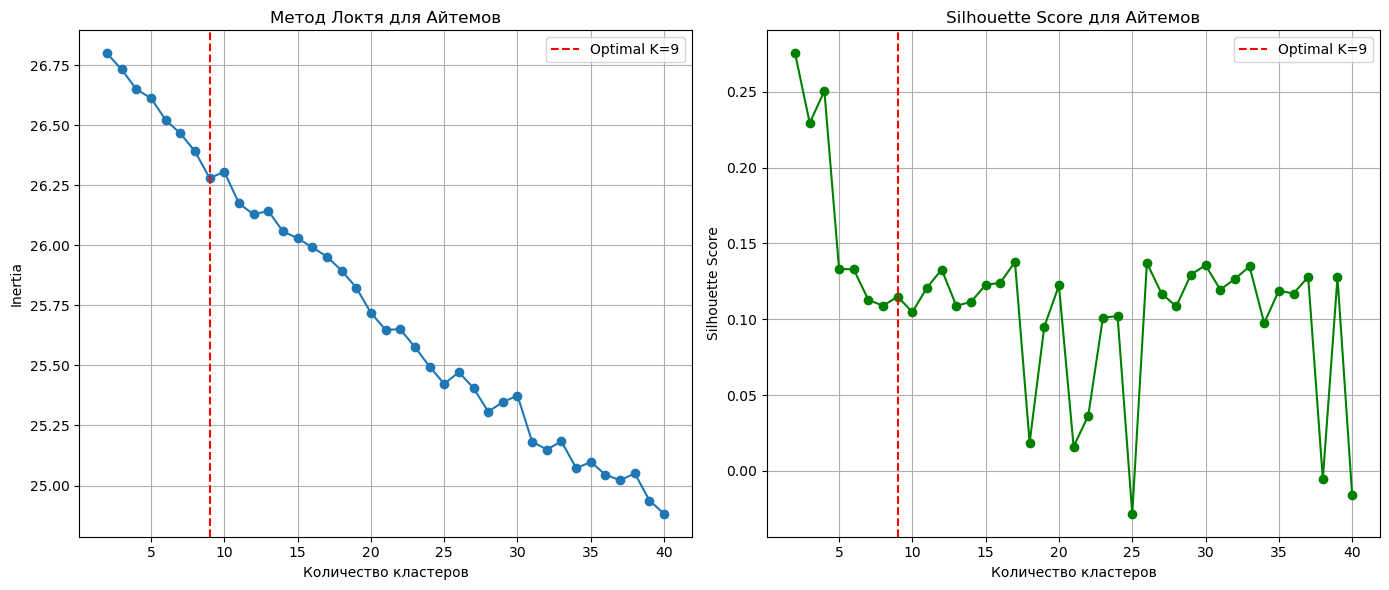

In [238]:
item_iters, item_inertias, item_silhouette, optimal_k = find_optimal_clusters(
    items_emb.values,
    min_k=2,   
    max_k=40,  
    step=1,
    criterion='inertia'
)

print(f"Оптимальное количество кластеров: {optimal_k}")

plt.figure(figsize=(14, 6))

# График инерции
plt.subplot(1, 2, 1)
plt.plot(item_iters, item_inertias, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод Локтя для Айтемов')
plt.grid(True)
if optimal_k:
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
    plt.legend()

# График коэффициента силуэта
plt.subplot(1, 2, 2)
plt.plot(item_iters, item_silhouette, marker='o', color='green')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score для Айтемов')
plt.grid(True)
if not np.isnan(optimal_k):
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
    plt.legend()

plt.tight_layout()
plt.show()


#### Из графика для силуэта можем видеть, что разбиение айтемов на кластеры по их эмбеддингам ничего не даст.

In [245]:
n_clusters_items = 9

kmeans_items = KMeans(n_clusters=n_clusters_items, random_state=42, n_init=10)

In [246]:
items_emb['item_cluster'] = kmeans_items.fit_predict(items_emb.values)

items_clusters = pd.DataFrame({
    'item_id': items_emb.index,
    'item_cluster': items_emb['item_cluster']
})

In [268]:
items_clusters[items_clusters['item_cluster'] == 0].shape[0]/items_clusters.shape[0]

0.8461716579191109

#### Действительно, почти все айтемы в нулевом кластере

#### Повторим те же действия для изображений и текста

In [275]:
items = items.set_index('item_id')

In [277]:
images = items[img_embedding_cols]
text = items[text_embedding_cols]

Определение оптимального K для KMeans (Айтемы): 100%|██████████| 39/39 [08:03<00:00, 12.41s/it]


Оптимальное количество кластеров: 11


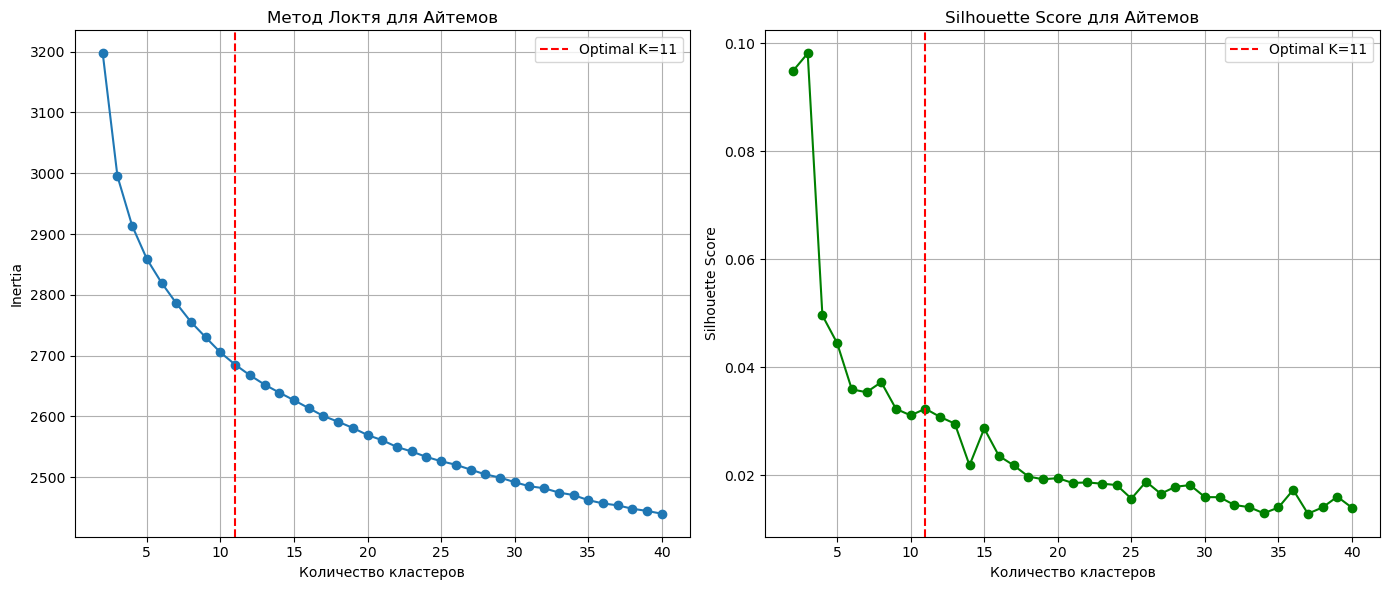

In [279]:
item_iters, item_inertias, item_silhouette, optimal_k = find_optimal_clusters(
    images.values,
    min_k=2,   
    max_k=40,  
    step=1,
    criterion='inertia'
)

print(f"Оптимальное количество кластеров: {optimal_k}")

plt.figure(figsize=(14, 6))

# График инерции
plt.subplot(1, 2, 1)
plt.plot(item_iters, item_inertias, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод Локтя для Айтемов')
plt.grid(True)
if optimal_k:
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
    plt.legend()

# График коэффициента силуэта
plt.subplot(1, 2, 2)
plt.plot(item_iters, item_silhouette, marker='o', color='green')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score для Айтемов')
plt.grid(True)
if not np.isnan(optimal_k):
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
    plt.legend()

plt.tight_layout()
plt.show()

#### Силуэт показывает, что 11 не самое оптимальное количество кластеров, но оставим так, как посчитал метод локтя

In [280]:
n_clusters_items = 11

kmeans_items = KMeans(n_clusters=n_clusters_items, random_state=42, n_init=10)

In [ ]:
images['image_cluster'] = kmeans_items.fit_predict(images.values)

images_clusters = pd.DataFrame({
    'item_id': images.index,
    'image_cluster': images['image_cluster']
})

In [286]:
images_clusters[images_clusters['image_cluster'] == 0].shape[0]/images_clusters.shape[0]

0.08675517134918184

#### Разбиение прошло лучше, чем с предыдущими эмбеддингами. Сделаем то же самое для текста

Определение оптимального K для KMeans (Айтемы): 100%|██████████| 39/39 [05:55<00:00,  9.13s/it]


Оптимальное количество кластеров: 10


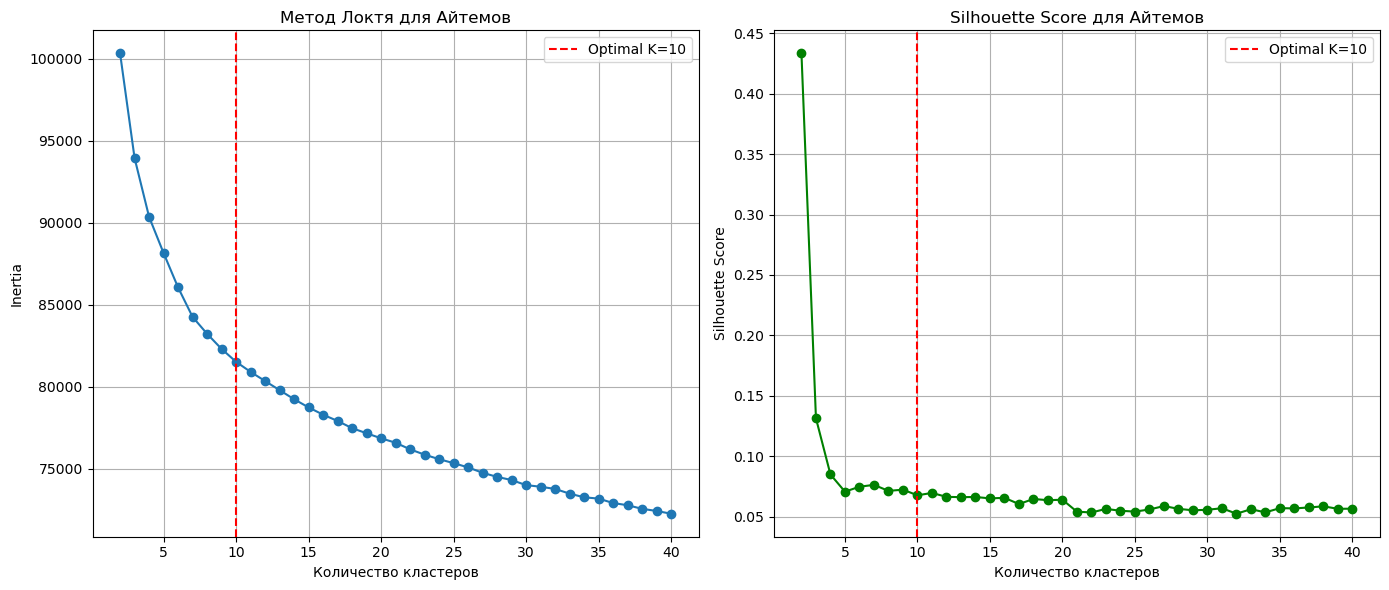

In [287]:
item_iters, item_inertias, item_silhouette, optimal_k = find_optimal_clusters(
    text.values,
    min_k=2,   
    max_k=40,  
    step=1,
    criterion='inertia'
)

print(f"Оптимальное количество кластеров: {optimal_k}")

plt.figure(figsize=(14, 6))

# График инерции
plt.subplot(1, 2, 1)
plt.plot(item_iters, item_inertias, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод Локтя для Айтемов')
plt.grid(True)
if optimal_k:
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
    plt.legend()

# График коэффициента силуэта
plt.subplot(1, 2, 2)
plt.plot(item_iters, item_silhouette, marker='o', color='green')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score для Айтемов')
plt.grid(True)
if not np.isnan(optimal_k):
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
    plt.legend()

plt.tight_layout()
plt.show()

In [288]:
n_clusters_items = 10

kmeans_items = KMeans(n_clusters=n_clusters_items, random_state=42, n_init=10)

In [ ]:
text['text_cluster'] = kmeans_items.fit_predict(images.values)

text_clusters = pd.DataFrame({
    'item_id': text.index,
    'text_cluster': text['text_cluster']
})

In [290]:
text_clusters[text_clusters['text_cluster'] == 0].shape[0]/images_clusters.shape[0]

0.09269836369249769

#### Функцию придется изменить, так как силуэт очень долго считается для пользователей

In [261]:
def find_optimal_clusters(data, min_k=2, max_k=100, step=1):

    iters = range(min_k, max_k + 1, step)
    inertias = []
    
    for k in tqdm(iters, desc="Определение оптимального K для KMeans (Пользователи)"):
        model = KMeans(n_clusters=k, random_state=42, n_init=10, verbose=0)
        model.fit(data)
        inertias.append(model.inertia_)
    
    kl = KneeLocator(iters, inertias, curve="convex", direction="decreasing")
    optimal_k = kl.elbow
    if optimal_k is None:
        print("Не удалось определить колено на графике инерции.")
    
    return iters, inertias, optimal_k

In [265]:
user_iters, user_inertias, optimal_k = find_optimal_clusters(users_emb.values, min_k=2, max_k=40, step=1)
   
print(f"Оптимальное количество кластеров: {optimal_k}")

Определение оптимального K для KMeans (Пользователи): 100%|██████████| 39/39 [47:43<00:00, 73.41s/it] 

Оптимальное количество кластеров: 24


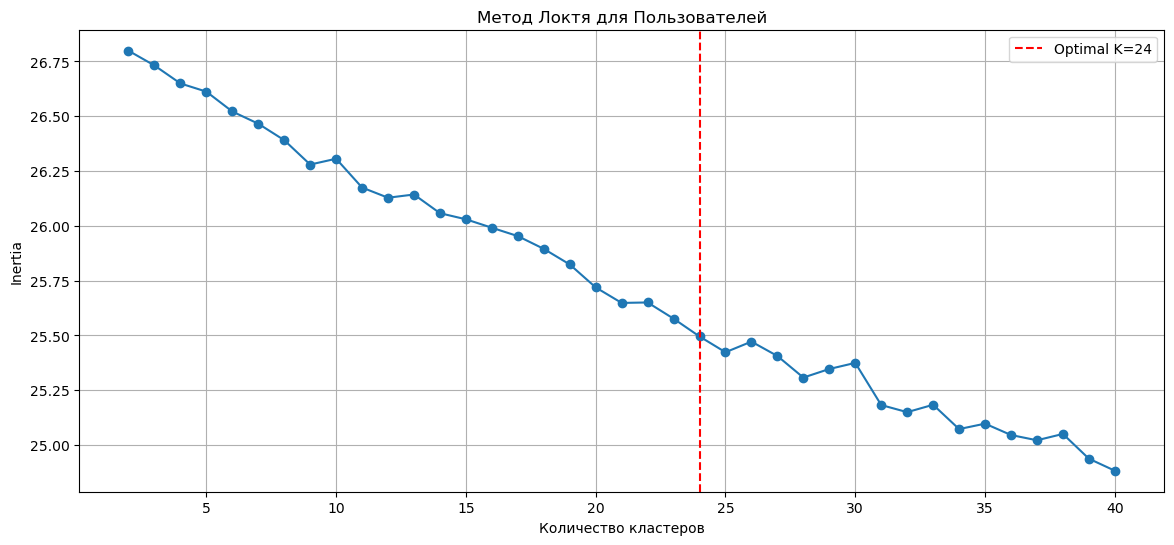

In [266]:
plt.figure(figsize=(14, 6))
plt.plot(item_iters, item_inertias, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод Локтя для Пользователей')
plt.grid(True)
if optimal_k:
    plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
    plt.legend()

plt.show()

In [267]:
n_clusters_users = 24  

kmeans_users = KMeans(n_clusters=n_clusters_users, random_state=42, n_init=10)
users_emb['user_cluster'] = kmeans_users.fit_predict(users_emb.values)

users_clusters = pd.DataFrame({
    'user_id': users_emb.index,
    'user_cluster': users_emb['user_cluster']
})

In [272]:
users_clusters[users_clusters['user_cluster'] == 0].shape[0]/users_clusters.shape[0]

0.02824696403674021

In [ ]:
users_clusters.to_parquet('users_clusters_2.parquet')
text_clusters.to_parquet('text_clusters_2.parquet')
images_clusters.to_parquet('images_clusters_2.parquet')

#### Разбиение по кластерам для пользователей более удачное, чем для айтемов по эмбеддингам из iALS, но занимает намного больше времени

In [292]:
from itertools import combinations
from collections import defaultdict

In [370]:
users_clusters = pd.read_parquet('users_clusters_2.parquet')
text_clusters = pd.read_parquet('text_clusters_2.parquet')
images_clusters = pd.read_parquet('images_clusters_2.parquet')

In [371]:
first_train_with_user_cluster = first_train.merge(users_clusters, on='user_id', how='left')

In [372]:
recommendations_with_user_cluster = recommendations_df.merge(users_clusters, on='user_id', how='left')

In [373]:
cluster_user_items_dict = first_train_with_user_cluster.groupby(['user_cluster', 'user_id'])['item_id'].apply(set).to_dict()

cluster_item_users_dict = first_train_with_user_cluster.groupby(['user_cluster', 'item_id'])['user_id'].apply(set).to_dict()

In [374]:
def compute_normalized_cooccurrence(row):
    candidate_item = row['item_id']
    user_id = row['user_id']
    user_cluster = row['user_cluster']

    interacted_items = cluster_user_items_dict.get((user_cluster, user_id), set())

    if not interacted_items:
        return 0.0  

    candidate_users = cluster_item_users_dict.get((user_cluster, candidate_item), set())
    candidate_popularity = len(candidate_users)
    if candidate_popularity == 0:
        return 0.0  
    
    cooccurrences = []
    for item in interacted_items:
        users = cluster_item_users_dict.get((user_cluster, item), set())

        co_users = candidate_users.intersection(users)
        co_count = len(co_users)

        normalized = co_count / candidate_popularity
        cooccurrences.append(normalized)
    
    return sum(cooccurrences) / len(cooccurrences) if cooccurrences else 0.0

In [375]:
recommendations_with_user_cluster['interacted_items'] = recommendations_with_user_cluster.progress_apply(
    lambda row: cluster_user_items_dict.get((row['user_cluster'], row['user_id']), set()), axis=1
)

100%|██████████| 450184/450184 [00:04<00:00, 99125.60it/s] 


In [376]:
recommendations_with_user_cluster['average_normalized_cooccurrence'] = recommendations_with_user_cluster.progress_apply(
    compute_normalized_cooccurrence, axis=1
)

100%|██████████| 450184/450184 [00:12<00:00, 35118.29it/s]


In [377]:
popularity = first_train_with_user_cluster.groupby(['user_cluster', 'item_id']).size().reset_index(name='item_cluster_popularity')

cluster_total_popularity = popularity.groupby('user_cluster')['item_cluster_popularity'].sum().reset_index(name='cluster_total_popularity')

popularity_normalized = popularity.merge(cluster_total_popularity, on='user_cluster', how='left')

popularity_normalized['item_cluster_popularity_normalized'] = popularity_normalized.apply(
    lambda row: row['item_cluster_popularity'] / row['cluster_total_popularity'] if row['cluster_total_popularity'] > 0 else 0,
    axis=1
)

recommendations_with_features = recommendations_with_user_cluster.merge(
    popularity_normalized[['user_cluster', 'item_id', 'item_cluster_popularity_normalized']],
    on=['user_cluster', 'item_id'], how='left'
)

recommendations_with_features['item_cluster_popularity_normalized'] = recommendations_with_features['item_cluster_popularity_normalized'].fillna(0)

In [378]:
first_train_with_image = first_train.merge(images_clusters, on='item_id', how='left')

first_train_with_image_cluster = first_train_with_image.merge(users_clusters, on='user_id', how='left')

user_image_freq = first_train_with_image_cluster.groupby(['user_id', 'image_cluster']).size().reset_index(name='user_image_cluster_freq')

user_total_interactions = first_train_with_image_cluster.groupby('user_id').size().reset_index(name='total_interactions')

user_image_freq = user_image_freq.merge(user_total_interactions, on='user_id', how='left')

user_image_freq['user_image_cluster_freq_normalized'] = user_image_freq['user_image_cluster_freq'] / user_image_freq['total_interactions']

recommendations_with_features = recommendations_with_features.merge(
    images_clusters, on='item_id', how='left'
).merge(
    user_image_freq[['user_id', 'image_cluster', 'user_image_cluster_freq_normalized']],
    on=['user_id', 'image_cluster'], how='left'
)

recommendations_with_features['user_image_cluster_freq_normalized'] = recommendations_with_features['user_image_cluster_freq_normalized'].fillna(0)

In [379]:
first_train_with_text = first_train.merge(text_clusters, on='item_id', how='left')

first_train_with_text_cluster = first_train_with_text.merge(users_clusters, on='user_id', how='left')

user_text_freq = first_train_with_text_cluster.groupby(['user_id', 'text_cluster']).size().reset_index(name='user_text_cluster_freq')

user_text_freq = user_text_freq.merge(user_total_interactions, on='user_id', how='left')

user_text_freq['user_text_cluster_freq_normalized'] = user_text_freq['user_text_cluster_freq'] / user_text_freq['total_interactions']

recommendations_with_features_final = recommendations_with_features.merge(
    text_clusters, on='item_id', how='left'
).merge(
    user_text_freq[['user_id', 'text_cluster', 'user_text_cluster_freq_normalized']],
    on=['user_id', 'text_cluster'], how='left'
)

recommendations_with_features_final['user_text_cluster_freq_normalized'] = recommendations_with_features_final['user_text_cluster_freq_normalized'].fillna(0)

In [380]:
final_recommendations_df = recommendations_with_features_final.copy()
final_recommendations_df['cluster_avg_normalized_cooccurrence'] = recommendations_with_user_cluster['average_normalized_cooccurrence']

In [381]:
# Шаг 11: Удаляем ненужные столбцы 
final_recommendations_df = final_recommendations_df.drop(['user_cluster', 'image_cluster', 'text_cluster', 'interacted_items'], axis=1)

In [382]:
final_recommendations_df = final_recommendations_df.drop(columns=['average_normalized_cooccurrence'])

In [383]:
final_recommendations_df.columns

Index(['user_id', 'item_id', 'bm_25_score', 'bm_25_rank', 'ials_feat_score',
       'ials_feat_rank', 'ials_score', 'ials_rank', 'tfidf_score',
       'tfidf_rank', 'weight', 'item_popul', 'inner_product', 'img_mean_dist',
       'img_min_dist', 'img_max_dist', 'img_median_dist', 'img_var_dist',
       'text_mean_dist', 'text_min_dist', 'text_max_dist', 'text_median_dist',
       'text_var_dist', 'avg_normalized_cooccurrence',
       'max_normalized_cooccurrence', 'min_normalized_cooccurrence',
       'median_normalized_cooccurrence', 'var_normalized_cooccurrence',
       'item_cluster_popularity_normalized',
       'user_image_cluster_freq_normalized',
       'user_text_cluster_freq_normalized',
       'cluster_avg_normalized_cooccurrence'],
      dtype='object')

In [384]:
final_recommendations_df.to_parquet('recommendations_df_final_val.parquet')

#### Проделав те же самые шаги для тестового датасета, а затем для датасетов с большим количеством кандидатов, проверим качество моделей с новыми признаками

In [395]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRanker, LGBMClassifier
import optuna

In [495]:
recommendations_df = pd.read_parquet('recommendations_df_final_val.parquet')

In [496]:
unique_users = recommendations_df['user_id'].unique()
train_users, val_users = train_test_split(unique_users, test_size=0.2, random_state=17)

train_df = recommendations_df[recommendations_df['user_id'].isin(train_users)]
val_df = recommendations_df[recommendations_df['user_id'].isin(val_users)]

In [420]:
cols = [col for col in recommendations_df.columns if col not in ['user_id'] + ['item_id'] + ['weight']]

In [422]:
def get_group(df):
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [497]:
group_train = get_group(train_df)
group_val = get_group(val_df)

In [424]:
def objective(trial):

    param = {
        'objective': 'lambdarank',
        'metric': 'map',  
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 4000),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'num_leaves': trial.suggest_int('num_leaves', 16, 32),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'early_stopping_rounds': 16,
        'random_state': 0,
    }

    model = LGBMRanker(**param)

    fit_params = {
        'X': train_df[cols],
        'y': train_df['weight'],
        'group': get_group(train_df),
        'eval_set': [(val_df[cols], val_df['weight'])],
        'eval_group': [get_group(val_df)],
        'eval_metric': 'map',
        'eval_at': (1, 5, 10),
        'feature_name': cols,
    }

    model.fit(**fit_params)
    best_map = max(model.evals_result_['valid_0']['map@10'])

    return best_map  

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

In [426]:
study.best_trial.params

{'learning_rate': 0.08145247564866283,
 'n_estimators': 1285,
 'max_depth': 5,
 'num_leaves': 31,
 'min_child_samples': 43,
 'reg_lambda': 0.17178836316525123,
 'colsample_bytree': 0.5463173012678405,
 'subsample': 0.9734022848654071}

In [427]:
best_params = study.best_trial.params
best_params['objective'] = 'lambdarank'
best_params['metric'] = 'map'
best_params['verbosity'] = -1
best_params['random_state'] = 0

fit_params = {
    'X': train_df[cols],
    'y': train_df['weight'],
    'group': get_group(train_df),
    'eval_set': [(val_df[cols], val_df['weight'])],
    'eval_group': [get_group(val_df)],
    'eval_metric': 'map',
    'eval_at': (1, 5, 10),
    'feature_name': cols,
}
listwise_model = LGBMRanker(**best_params, early_stopping_rounds = 16)
listwise_model.fit(**fit_params)

LGBMRanker(colsample_bytree=0.5463173012678405, early_stopping_rounds=16,
           learning_rate=0.08145247564866283, max_depth=5, metric='map',
           min_child_samples=43, n_estimators=1285, objective='lambdarank',
           random_state=0, reg_lambda=0.17178836316525123,
           subsample=0.9734022848654071, verbosity=-1)

In [499]:
test_df = pd.read_parquet('recommendations_df_final_test.parquet')

In [500]:
listwise_df = test_df[["user_id", "item_id"]].copy()
listwise_df["listwise_score"] = listwise_model.predict(test_df[cols])
listwise_df = listwise_df.sort_values(["user_id", "listwise_score"], ascending=[True, False])

In [501]:
listwise_df['rank'] = listwise_df.groupby('user_id').cumcount() + 1

In [505]:
listwise_df.to_parquet('listwise_df_10_all.parquet')

In [502]:
listwise_metrics = calc_metrics(
    metrics=metrics,
    reco=(
        listwise_df
        .rename(columns={'listwise_rank': Columns.Rank})
        [[Columns.User, Columns.Item, Columns.Rank]]
    ),
    interactions=(
        warm_test
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    prev_interactions=(
        first_train
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    catalog=catalog
)

In [503]:
listwise_metrics

{'hit_rate@1': 0.3409546576187539,
 'hit_rate@5': 0.5591455891425047,
 'hit_rate@10': 0.6307834669956817,
 'Recall@1': 0.15508366748920419,
 'Recall@5': 0.31626889265885255,
 'Recall@10': 0.3729083127698951,
 'MRR@1': 0.3409546576187539,
 'MRR@5': 0.42380732058400167,
 'MRR@10': 0.4336057070885109,
 'MAP@1': 0.15508366748920419,
 'MAP@5': 0.2540368599629858,
 'MAP@10': 0.2679132715573377,
 'pop_bias@10': 819.8786628624306,
 'serendipity@10': 0.0045350556820206896}

In [433]:
models_results_df_test = pd.DataFrame(index=list(metrics.keys()))

In [434]:
models_results_df_test["LGBM_10_full"] = [listwise_metrics[metric] for metric in models_results_df_test.index]

In [435]:
models_results_df_test

,LGBM_10_full
hit_rate@1,0.340800
hit_rate@5,0.559570
hit_rate@10,0.631169
Recall@1,0.154958
Recall@5,0.316973
Recall@10,0.373332
MAP@1,0.154958
MAP@5,0.254153
MAP@10,0.267943
MRR@1,0.340800


#### Метрики не только стали выше, MRR и MAP стали выше, чем в версии с большим количеством кандидатогенераторов. Осталось проверить модель, в которой будет больше кандидатов. Но перед этим посмотрим на важность признаков

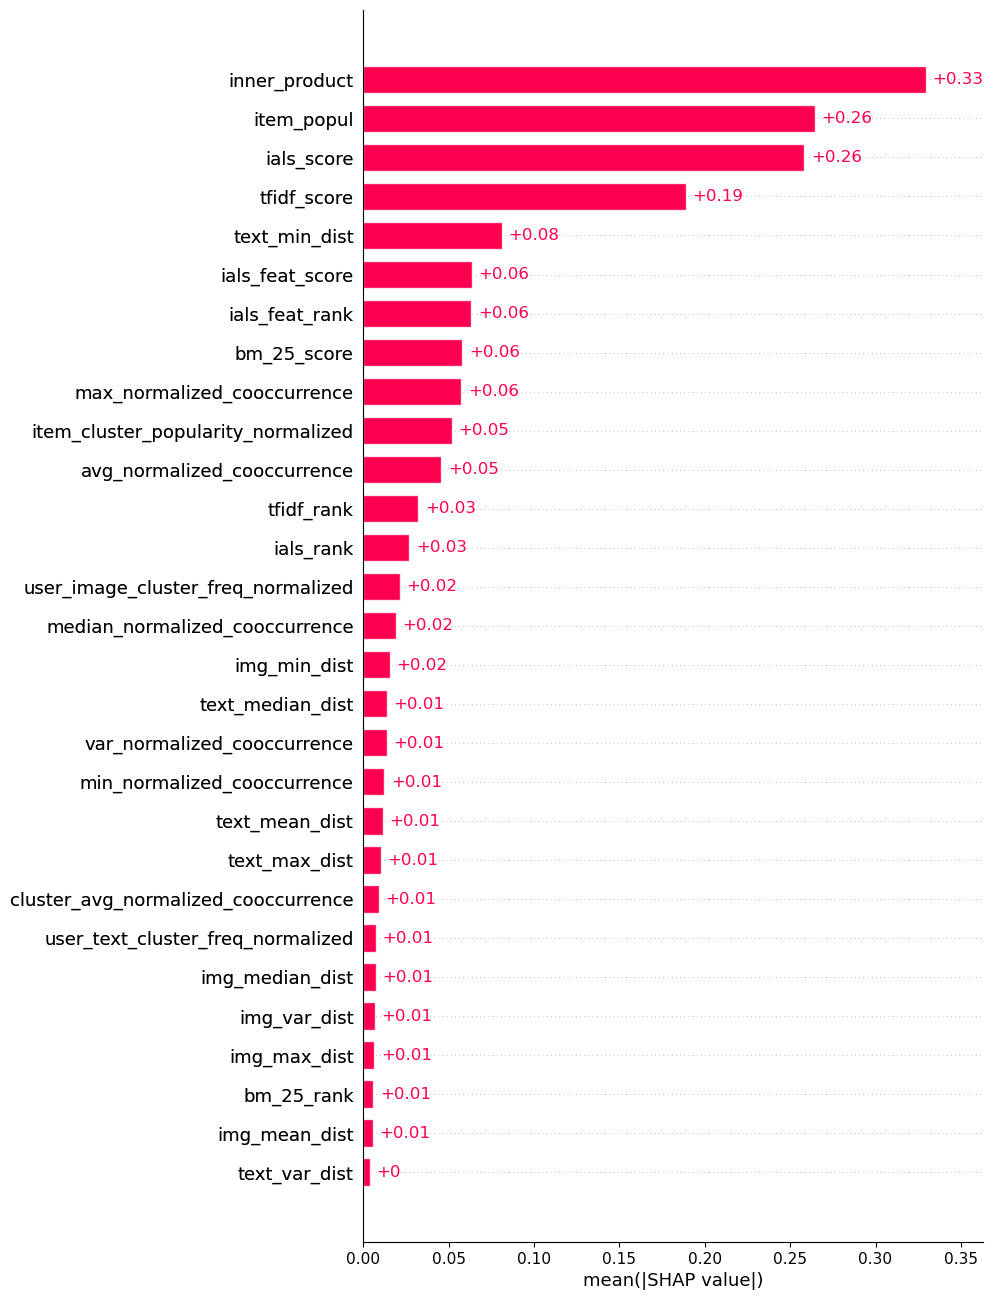

In [436]:
import shap
explainer = shap.Explainer(listwise_model)
shap_values = explainer(test_df[cols])
shap.plots.bar(shap_values, max_display=len(cols))

In [789]:
recommendations_df = pd.read_parquet('recommendations_df_final_val_2_50.parquet')

In [790]:
train_df = recommendations_df[recommendations_df['user_id'].isin(train_users)]
val_df = recommendations_df[recommendations_df['user_id'].isin(val_users)]

In [791]:
group_train = get_group(train_df)
group_val = get_group(val_df)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

In [493]:
study.best_trial.params

{'learning_rate': 0.09251809178217157,
 'n_estimators': 1520,
 'max_depth': 4,
 'num_leaves': 21,
 'min_child_samples': 57,
 'reg_lambda': 0.034631848853420216,
 'colsample_bytree': 0.9326208502799169,
 'subsample': 0.5629955079736929}

In [459]:
best_params = study.best_trial.params
best_params['objective'] = 'lambdarank'
best_params['metric'] = 'map'
best_params['verbosity'] = -1
best_params['random_state'] = 0

fit_params = {
    'X': train_df[cols],
    'y': train_df['weight'],
    'group': get_group(train_df),
    'eval_set': [(val_df[cols], val_df['weight'])],
    'eval_group': [get_group(val_df)],
    'eval_metric': 'map',
    'eval_at': (1, 5, 10),
    'feature_name': cols,
}
listwise_model = LGBMRanker(**best_params, early_stopping_rounds = 16)
listwise_model.fit(**fit_params)

LGBMRanker(colsample_bytree=0.9326208502799169, early_stopping_rounds=16,
           learning_rate=0.09251809178217157, max_depth=4, metric='map',
           min_child_samples=57, n_estimators=1520, num_leaves=21,
           objective='lambdarank', random_state=0,
           reg_lambda=0.034631848853420216, subsample=0.5629955079736929,
           verbosity=-1)

In [788]:
test_df = pd.read_parquet('recommendations_df_final_test_2_50.parquet')

In [480]:
test_df.columns

Index(['user_id', 'item_id', 'bm_25_score', 'bm_25_rank', 'ials_feat_score',
       'ials_feat_rank', 'ials_score', 'ials_rank', 'tfidf_score',
       'tfidf_rank', 'weight', 'item_popul_x', 'inner_product',
       'img_mean_dist', 'img_min_dist', 'img_max_dist', 'img_median_dist',
       'img_var_dist', 'text_mean_dist', 'text_min_dist', 'text_max_dist',
       'text_median_dist', 'text_var_dist', 'avg_normalized_cooccurrence',
       'max_normalized_cooccurrence', 'min_normalized_cooccurrence',
       'median_normalized_cooccurrence', 'var_normalized_cooccurrence',
       'item_cluster_popularity_normalized',
       'user_image_cluster_freq_normalized',
       'user_text_cluster_freq_normalized',
       'cluster_avg_normalized_cooccurrence', 'item_popul_y'],
      dtype='object')

In [486]:
listwise_df = test_df[["user_id", "item_id"]].copy()
listwise_df["listwise_score"] = listwise_model.predict(test_df[cols])
listwise_df = listwise_df.sort_values(["user_id", "listwise_score"], ascending=[True, False])

In [487]:
listwise_df['rank'] = listwise_df.groupby('user_id').cumcount() + 1

In [488]:
listwise_metrics = calc_metrics(
    metrics=metrics,
    reco=(
        listwise_df
        .rename(columns={'listwise_rank': Columns.Rank})
        [[Columns.User, Columns.Item, Columns.Rank]]
    ),
    interactions=(
        warm_test
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    prev_interactions=(
        first_train
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    catalog=catalog
)

In [490]:
models_results_df_test["LGBM_50_full"] = [listwise_metrics[metric] for metric in models_results_df_test.index]

In [491]:
models_results_df_test

,LGBM_10_full,LGBM_50_full
hit_rate@1,0.340800,0.341147
hit_rate@5,0.559570,0.562461
hit_rate@10,0.631169,0.642852
Recall@1,0.154958,0.155093
Recall@5,0.316973,0.317850
Recall@10,0.373332,0.379559
MAP@1,0.154958,0.155093
MAP@5,0.254153,0.254604
MAP@10,0.267943,0.269399
MRR@1,0.340800,0.341147


#### Получилось добиться рекордных метрик. Однако влияние популярности айтема очень сильно возросло

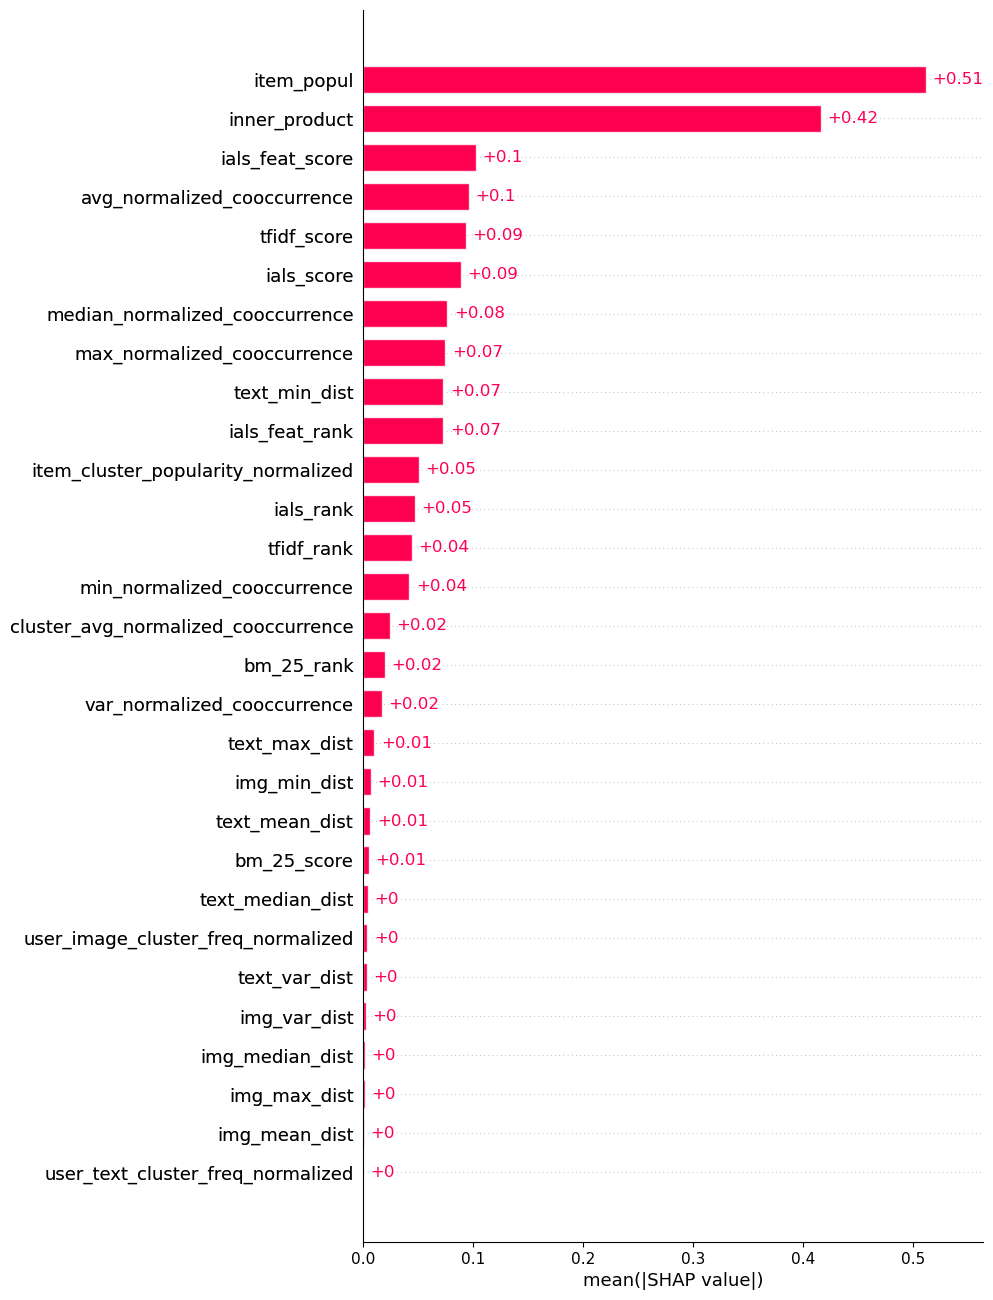

In [492]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(test_df[cols])
shap.plots.bar(shap_values, max_display=len(cols))

In [494]:
listwise_df.to_parquet('listwise_df_50_all.parquet')

#### Отрежем все признаки, чей вклад невелик, а именно меньше, чем 0.04

In [533]:
cols = [col for col in recommendations_df.columns if col not in ['user_id'] + ['item_id'] + ['weight']
        + ['user_text_cluster_freq_normalized'] + ['img_mean_dist'] + ['img_max_dist'] + ['img_median_dist']
       + ['img_var_dist'] + ['text_var_dist'] + ['user_image_cluster_freq_normalized'] + ['text_median_dist']
       + ['bm_25_score'] + ['text_mean_dist'] + ['img_min_dist'] + ['text_max_dist'] + ['var_normalized_cooccurrence']
       + ['bm_25_rank'] + ['cluster_avg_normalized_cooccurrence']]

In [560]:
len(cols)

14

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

In [551]:
study.best_trial.params

{'learning_rate': 0.09842925268119498,
 'n_estimators': 3650,
 'max_depth': 5,
 'num_leaves': 29,
 'min_child_samples': 167,
 'reg_lambda': 4.9332176938907475,
 'colsample_bytree': 0.7139220382472067,
 'subsample': 0.5077965065425056}

In [552]:
best_params = study.best_trial.params
best_params['objective'] = 'lambdarank'
best_params['metric'] = 'map'
best_params['verbosity'] = -1
best_params['random_state'] = 0

fit_params = {
    'X': train_df[cols],
    'y': train_df['weight'],
    'group': get_group(train_df),
    'eval_set': [(val_df[cols], val_df['weight'])],
    'eval_group': [get_group(val_df)],
    'eval_metric': 'map',
    'eval_at': (1, 5, 10),
    'feature_name': cols,
}
listwise_model = LGBMRanker(**best_params, early_stopping_rounds = 16)
listwise_model.fit(**fit_params)

LGBMRanker(colsample_bytree=0.7139220382472067, early_stopping_rounds=16,
           learning_rate=0.09842925268119498, max_depth=5, metric='map',
           min_child_samples=167, n_estimators=3650, num_leaves=29,
           objective='lambdarank', random_state=0,
           reg_lambda=4.9332176938907475, subsample=0.5077965065425056,
           verbosity=-1)

In [553]:
listwise_df = test_df[["user_id", "item_id"]].copy()
listwise_df["listwise_score"] = listwise_model.predict(test_df[cols])
listwise_df = listwise_df.sort_values(["user_id", "listwise_score"], ascending=[True, False])

In [554]:
listwise_df['rank'] = listwise_df.groupby('user_id').cumcount() + 1

In [555]:
listwise_metrics = calc_metrics(
    metrics=metrics,
    reco=(
        listwise_df
        .rename(columns={'listwise_rank': Columns.Rank})
        [[Columns.User, Columns.Item, Columns.Rank]]
    ),
    interactions=(
        warm_test
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    prev_interactions=(
        first_train
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    catalog=catalog
)

In [556]:
models_results_df_test["LGBM_50_final"] = [listwise_metrics[metric] for metric in models_results_df_test.index]

In [557]:
models_results_df_test

,LGBM_10_full,LGBM_50_full,LGBM_50_final
hit_rate@1,0.340800,0.341147,0.338063
hit_rate@5,0.559570,0.562461,0.559570
hit_rate@10,0.631169,0.642852,0.643276
Recall@1,0.154958,0.155093,0.154573
Recall@5,0.316973,0.317850,0.317079
Recall@10,0.373332,0.379559,0.379945
MAP@1,0.154958,0.155093,0.154573
MAP@5,0.254153,0.254604,0.254106
MAP@10,0.267943,0.269399,0.269033
MRR@1,0.340800,0.341147,0.338063


In [559]:
listwise_df.to_parquet('listwise_df_50_final.parquet')

### Попробуем генерировать кандидатов с помощью эмбеддингов текста

In [587]:
text = text.drop(columns = ['text_cluster'])

In [593]:
user_item_counts = first_train.groupby(['user_id', 'item_id']).size().reset_index(name='counts')

user_item_embeddings = user_item_counts.merge(text, left_on='item_id', right_index=True, how='left')

embedding_cols = text.columns
for col in embedding_cols:
    user_item_embeddings[col] = user_item_embeddings[col] * user_item_embeddings['counts']

user_embedding_sum = user_item_embeddings.groupby('user_id')[embedding_cols].sum()

user_total_counts = user_item_embeddings.groupby('user_id')['counts'].sum()

user_mean_embedding = user_embedding_sum.div(user_total_counts, axis=0)

user_mean_embedding_normalized = normalize(user_mean_embedding.values, axis=1)
user_mean_embedding_normalized = pd.DataFrame(user_mean_embedding_normalized, index=user_mean_embedding.index, columns=embedding_cols)

In [594]:
item_embeddings_normalized = normalize(text.values, axis=1)
item_embeddings_normalized = pd.DataFrame(item_embeddings_normalized, index=text.index, columns=text.columns)

In [595]:
users_to_recommend = first_val['user_id'].unique()

user_mean_embedding_normalized = user_mean_embedding_normalized.loc[user_mean_embedding_normalized.index.intersection(users_to_recommend)]
users_to_recommend = user_mean_embedding_normalized.index.values

user_embeddings = user_mean_embedding_normalized.values  
item_embeddings = item_embeddings_normalized.values  

cos_similarity = np.dot(user_embeddings, item_embeddings.T) 

user_interacted_items = first_train.groupby('user_id')['item_id'].apply(set).to_dict()

In [596]:
all_item_ids = text.index.values

recommendations = []

for user_idx, user_id in enumerate(tqdm(users_to_recommend, desc="Генерация рекомендаций")):

    user_similarities = cos_similarity[user_idx]
    
    interacted_items = user_interacted_items.get(user_id, set())
    
    if interacted_items:
        interacted_mask = np.isin(all_item_ids, list(interacted_items))
        user_similarities[interacted_mask] = -np.inf
    
    top_n = 10
    if np.sum(user_similarities > -np.inf) >= top_n:
        top_n_indices = np.argpartition(user_similarities, -top_n)[-top_n:]
        top_n_sorted_indices = top_n_indices[np.argsort(-user_similarities[top_n_indices])]
    else:
        top_n_sorted_indices = np.argsort(-user_similarities)[:top_n]
    
    recommended_item_ids = all_item_ids[top_n_sorted_indices]
    recommended_scores = user_similarities[top_n_sorted_indices]
    
    for rank, (item_id, score) in enumerate(zip(recommended_item_ids, recommended_scores), start=1):
        recommendations.append({
            'user_id': user_id,
            'item_id': item_id,
            'score': score,
            'rank': rank
        })

text_recos = pd.DataFrame(recommendations)

Генерация рекомендаций: 100%|██████████| 25935/25935 [00:09<00:00, 2821.33it/s]


In [597]:
calc_metrics(
    metrics=metrics,
    reco=text_recos,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)

{'hit_rate@1': 0.07480239059186428,
 'hit_rate@5': 0.1125506072874494,
 'hit_rate@10': 0.12924619240408713,
 'Recall@1': 0.023925197609408137,
 'Recall@5': 0.042095623674571044,
 'Recall@10': 0.04913244650086755,
 'MRR@1': 0.07480239059186428,
 'MRR@5': 0.08923141186299081,
 'MRR@10': 0.0914846793418222,
 'MAP@1': 0.023925197609408137,
 'MAP@5': 0.033793458003984325,
 'MAP@10': 0.035040248668068215,
 'pop_bias@10': 172.50690187005978,
 'serendipity@10': 0.000777737159864522}

### Визуализируем новые рекоммендации для пользователей

In [601]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#### Для финальных рекомендаций с 10 кандидатами от кандидатогенераторов

In [701]:
listwise_df = pd.read_parquet('listwise_df_10_all.parquet')

In [702]:
recommendations_df = pd.read_parquet('recommendations_df_final_test.parquet')

In [602]:
image_folder = 'images'

In [603]:
item_to_filename = items.reset_index().set_index('item_id')['index'].to_dict()

In [612]:
random_top_user = 1038427

In [703]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_top_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [704]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_top_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] == 1]['item_id'].tolist()

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_top_user}", item_to_filename, image_folder,
              highlight_items=interacted_recommendations)

In [708]:
random_single_user = 1125623

In [710]:
single_user_recommendations = listwise_df[listwise_df['user_id'] == random_single_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [711]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_single_user) &
                                                     (recommendations_df['item_id'].isin(single_user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] == 1]['item_id'].tolist()

In [ ]:
display_images(single_user_recommendations, f"Первые 10 рекомендаций для пользователя {random_single_user}", 
               item_to_filename, image_folder, highlight_items=interacted_recommendations)

In [713]:
random_four_user = 2149185

In [717]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_four_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [718]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_four_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] > 0]['item_id'].tolist()

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_four_user}", 
                      item_to_filename, image_folder, highlight_items=interacted_recommendations)

In [720]:
random_four_user = 2849798

In [723]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_four_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [724]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_four_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] > 0]['item_id'].tolist()

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_four_user}", 
                      item_to_filename, image_folder, highlight_items=interacted_recommendations)

In [726]:
user_real_interactions = warm_test[warm_test['user_id'] == random_four_user]['item_id'].tolist()

In [734]:
first_train['item_id'].isin(user_real_interactions).sum()

148

#### Для финальных рекомендаций с 10 кандидатами от кандидатогенераторов

In [739]:
listwise_df = pd.read_parquet('listwise_df_50_final.parquet')

In [817]:
recommendations_df = pd.read_parquet('recommendations_df_final_test_2_50.parquet')

In [743]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_top_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [744]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_top_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] == 1]['item_id'].tolist()

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_top_user}", item_to_filename, image_folder,
              highlight_items=interacted_recommendations)

In [746]:
single_user_recommendations = listwise_df[listwise_df['user_id'] == random_single_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [747]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_single_user) &
                                                     (recommendations_df['item_id'].isin(single_user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] == 1]['item_id'].tolist()

In [ ]:
display_images(single_user_recommendations, f"Первые 10 рекомендаций для пользователя {random_single_user}", 
               item_to_filename, image_folder, highlight_items=interacted_recommendations)

In [749]:
random_four_user = 2149185

In [750]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_four_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [751]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_four_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] > 0]['item_id'].tolist()

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_four_user}", 
                      item_to_filename, image_folder, highlight_items=interacted_recommendations)

In [753]:
random_four_user = 2849798

In [754]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_four_user].sort_values(by='rank').head(10)['item_id'].tolist()

user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_four_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] > 0]['item_id'].tolist()

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_four_user}", 
                      item_to_filename, image_folder, highlight_items=interacted_recommendations)

In [793]:
cols = [col for col in recommendations_df.columns if col not in ['user_id'] + ['item_id'] + ['weight']
        + ['user_text_cluster_freq_normalized'] + ['img_mean_dist'] + ['img_max_dist'] + ['img_median_dist']
       + ['img_var_dist'] + ['text_var_dist'] + ['user_image_cluster_freq_normalized'] + ['text_median_dist']
        + ['text_mean_dist'] + ['img_min_dist'] + ['text_max_dist']]

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

In [812]:
study.best_trial.params

{'learning_rate': 0.08075965324579715,
 'n_estimators': 1557,
 'max_depth': 6,
 'num_leaves': 32,
 'min_child_samples': 114,
 'reg_lambda': 0.6845006074233676,
 'colsample_bytree': 0.9822293180509217,
 'subsample': 0.6184860530349535}

In [806]:
best_params = study.best_trial.params
best_params['objective'] = 'lambdarank'
best_params['metric'] = 'map'
best_params['verbosity'] = -1
best_params['random_state'] = 0

fit_params = {
    'X': train_df[cols],
    'y': train_df['weight'],
    'group': get_group(train_df),
    'eval_set': [(val_df[cols], val_df['weight'])],
    'eval_group': [get_group(val_df)],
    'eval_metric': 'map',
    'eval_at': (1, 5, 10),
    'feature_name': cols,
}
listwise_model = LGBMRanker(**best_params, early_stopping_rounds = 16)
listwise_model.fit(**fit_params)

LGBMRanker(colsample_bytree=0.9822293180509217, early_stopping_rounds=16,
           learning_rate=0.08075965324579715, max_depth=6, metric='map',
           min_child_samples=114, n_estimators=1557, num_leaves=32,
           objective='lambdarank', random_state=0,
           reg_lambda=0.6845006074233676, subsample=0.6184860530349535,
           verbosity=-1)

In [796]:
test_df = test_df.drop(columns = ['item_popul_y'])
test_df = test_df.rename(columns={'item_popul_x': 'item_popul'})

In [807]:
listwise_df = test_df[["user_id", "item_id"]].copy()
listwise_df["listwise_score"] = listwise_model.predict(test_df[cols])
listwise_df = listwise_df.sort_values(["user_id", "listwise_score"], ascending=[True, False])

In [808]:
listwise_df['rank'] = listwise_df.groupby('user_id').cumcount() + 1

In [809]:
listwise_metrics = calc_metrics(
    metrics=metrics,
    reco=(
        listwise_df
        .rename(columns={'listwise_rank': Columns.Rank})
        [[Columns.User, Columns.Item, Columns.Rank]]
    ),
    interactions=(
        warm_test
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    prev_interactions=(
        first_train
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    catalog=catalog
)

In [810]:
models_results_df_test["LGBM_50_final_final"] = [listwise_metrics[metric] for metric in models_results_df_test.index]

In [811]:
models_results_df_test

,LGBM_10_full,LGBM_50_full,LGBM_50_final,LGBM_50_final_final
hit_rate@1,0.340800,0.341147,0.338063,0.340762
hit_rate@5,0.559570,0.562461,0.559570,0.561420
hit_rate@10,0.631169,0.642852,0.643276,0.643006
Recall@1,0.154958,0.155093,0.154573,0.155421
Recall@5,0.316973,0.317850,0.317079,0.317850
Recall@10,0.373332,0.379559,0.379945,0.379559
MAP@1,0.154958,0.155093,0.154573,0.155421
MAP@5,0.254153,0.254604,0.254106,0.254917
MAP@10,0.267943,0.269399,0.269033,0.269722
MRR@1,0.340800,0.341147,0.338063,0.340762


In [813]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_top_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [818]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_top_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] == 1]['item_id'].tolist()

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_top_user}", item_to_filename, image_folder,
              highlight_items=interacted_recommendations)

In [820]:
single_user_recommendations = listwise_df[listwise_df['user_id'] == random_single_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [821]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_single_user) &
                                                     (recommendations_df['item_id'].isin(single_user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] == 1]['item_id'].tolist()

In [ ]:
display_images(single_user_recommendations, f"Первые 10 рекомендаций для пользователя {random_single_user}", 
               item_to_filename, image_folder, highlight_items=interacted_recommendations)

In [823]:
random_four_user = 2149185

In [824]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_four_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [825]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_four_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] > 0]['item_id'].tolist()

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_four_user}", 
                      item_to_filename, image_folder, highlight_items=interacted_recommendations)

In [827]:
random_four_user = 2849798

In [828]:
user_recommendations = listwise_df[listwise_df['user_id'] == random_four_user].sort_values(by='rank').head(10)['item_id'].tolist()

In [829]:
user_recommendations_df = recommendations_df[(recommendations_df['user_id'] == random_four_user) &
                                                     (recommendations_df['item_id'].isin(user_recommendations))]

interacted_recommendations = user_recommendations_df[user_recommendations_df['weight'] > 0]['item_id'].tolist()

In [ ]:
display_images(user_recommendations, f"Первые 10 рекомендаций для пользователя {random_four_user}", 
                      item_to_filename, image_folder, highlight_items=interacted_recommendations)

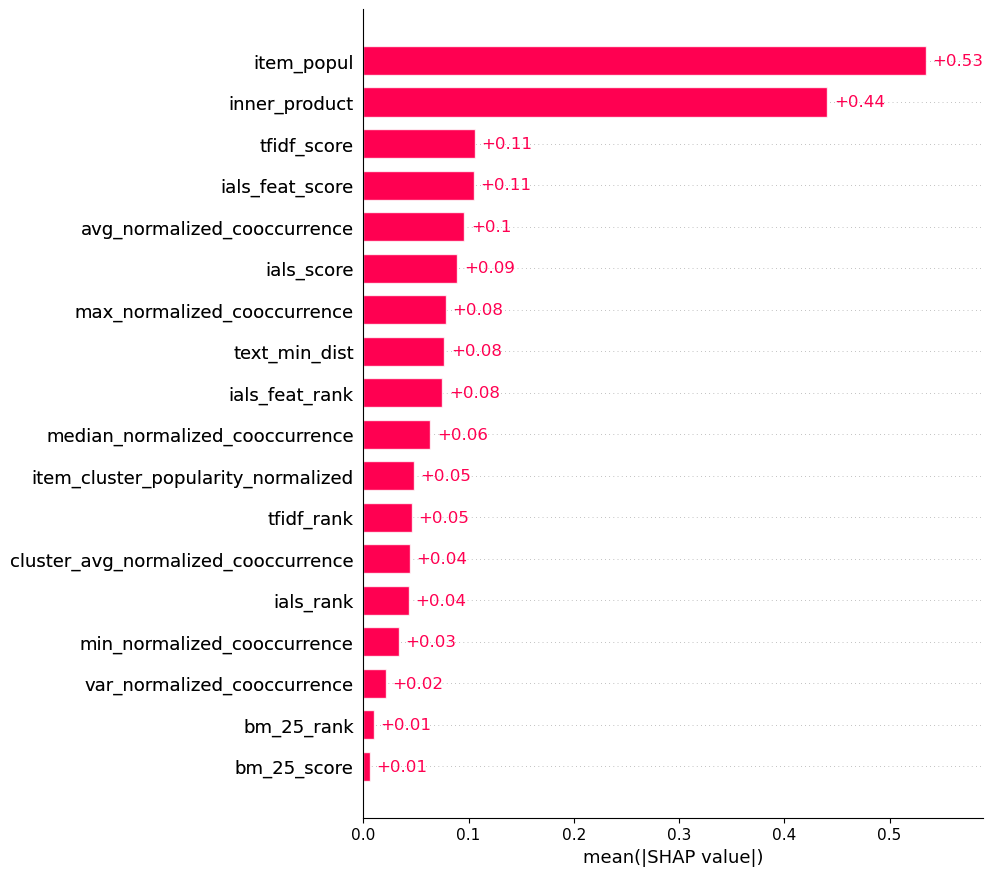

In [831]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(test_df[cols])
shap.plots.bar(shap_values, max_display=len(cols))